In [54]:
# import packages 导入库，搭建环境
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings 可以删除
import warnings
warnings.filterwarnings('ignore')

# 为了让matplotlib里显示中文字符
import matplotlib.font_manager as fm 
matplotlib.rcParams['font.family'] = 'Microsoft Yahei' # 设置字体

In [2]:
df = pd.read_csv("fraud_oracle.csv")

In [3]:
df.head().T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


In [4]:
df.columns= ['事故月份',
            '事故月中周数',
            '事故周中天数',
            '品牌',
            '事故发生区域',
            '出险周中天数',
            '出险月份',
            '出险月中周数',
            '出险人性别',
            '出险人婚姻状况',
            '出险人年龄',
            '责任划分',
            '保单类别',
            '车辆类别',
            '车辆价格',
            '是否骗保',
            '保单编号',
            '客服编号',
            '起付额',
            '驾驶员评级',
            '事故距离保单生效天数',
            '出险距离保单生效天数',
            '历史出险次数',
            '车龄',
            '投保人年龄',
            '是否出警',
            '是否有目击者',
            '中介类型',
            '补充出险次数',
            '出险距离地址变动时间',
            '投保人车辆数',
            '事故年份',
            '车险类别']

In [5]:
df[['事故月份', '出险月份']] = df[['事故月份', '出险月份']].replace({'Dec': '十二月',
                                                                'Nov': '十一月',
                                                                'Oct': '十月',
                                                                'Sep': '九月',
                                                                'Aug': '八月',
                                                                'Jul': '七月',
                                                                'Jun': '六月',
                                                                'May': '五月',
                                                                'Apr': '四月',
                                                                'Mar': '三月',
                                                                'Feb': '二月',
                                                                'Jan': '一月'})

In [6]:
df[['事故周中天数', '出险周中天数']] = df[['事故周中天数', '出险周中天数']]\
    .replace({'Monday': '周一',
            'Tuesday': '周二',
            'Wednesday': '周三',
            'Thursday': '周四',
            'Friday': '周五',
            'Saturday': '周六',
            'Sunday': '周日',})

In [7]:
df['品牌'] = df['品牌'].replace({'Honda': '本田',
                                'Toyota': '丰田',
                                'Ford': '福特',
                                'Mazda': '马自达',
                                'Chevrolet': '雪佛兰',
                                'Pontiac': '庞蒂亚克',
                                'Accura': '讴歌',
                                'Dodge': '道奇',
                                'Mercury': '别克',
                                'Jaguar': '捷豹',
                                'Nisson': '日产',
                                'VW': '大众',
                                'Saab': '萨博',
                                'Saturn': '现代',
                                'Porche': '保时捷',
                                'BMW': '宝马',
                                'Mecedes': '奔驰',
                                'Ferrari': '法拉利',
                                'Lexus': '凌志'})

In [8]:
df['事故发生区域'] = df['事故发生区域'].replace({'Urban': '城区', 'Rural': '农村'})

In [9]:
df['出险人性别'] = df['出险人性别'].replace({'Male': '男', 'Female': '女'})

In [10]:
df['出险人婚姻状况'] = df['出险人婚姻状况'].replace({'Single': '单身',
                                                'Married': '有配偶',
                                                'Widow': '丧偶',
                                                'Divorced': '离异'})

In [11]:
df['责任划分'] = df['责任划分'].replace({'Policy Holder': '出险人', 'Third Party': '第三方'})

In [13]:
df['保单类别'] = df['保单类别'].replace({'Sport - Liability': '跑车-第三者险',
                                        'Sport - Collision': '跑车-车损险',
                                        'Sedan - Liability': '轿车-第三者险',
                                        'Utility - All Perils': 'SUV-全险',
                                        'Sedan - All Perils': '轿车-全险',
                                        'Sedan - Collision': '轿车-车损险',
                                        'Utility - Collision': 'SUV-车损险',
                                        'Utility - Liability': 'SUV-第三者险',
                                        'Sport - All Perils': '跑车-车损险'})

In [16]:
df['车辆类别'] = df['车辆类别'].replace({'Sport': '跑车', 'Sedan': '轿车', 'Utility': 'SUV'})

In [22]:
df['车辆价格'] = df['车辆价格'].replace({'more than 69000': '大于50万',
                                        '20000 to 29000': '10-20万',
                                        '30000 to 39000': '20-30万',
                                        'less than 20000': '小于10万',
                                        '40000 to 59000': '30-40万',
                                        '60000 to 69000': '40-50万'})

In [25]:
df['事故距离保单生效天数'] = df['事故距离保单生效天数']\
    .replace({'more than 30': '大于30天',
              '16 to 30': '16-30天',
              'none': '无',
              '1 to 7': '1-7天',
              '8 to 15': '8-15天'})

In [26]:
df['出险距离保单生效天数'] = df['出险距离保单生效天数']\
    .replace({'more than 30': '大于30天',
              '16 to 30': '16-30天',
              'none': '无',
              '1 to 7': '1-7天',
              '8 to 15': '8-15天'})

In [28]:
df['历史出险次数'] = df['历史出险次数'].replace({'none': '无', 'more than 4': '大于4'})

In [30]:
df['车龄'] = df['车龄'].replace({'3 years': '2-3年',
                                '6 years': '5-6年',
                                '7 years': '6-7年',
                                'more than 7': '7年以上',
                                '5 years': '4-5年',
                                'new': '1年以下',
                                '4 years': '3-4年',
                                '2 years': '1-2年'})

In [33]:
df['投保人年龄'] = df['投保人年龄'].replace({'26 to 30': '26-30岁',
                                           '31 to 35': '31-35岁',
                                           '41 to 50': '41-50岁',
                                           '51 to 65': '51-65岁',
                                           '21 to 25': '21-25岁',
                                           '36 to 40': '36-40岁',
                                           '16 to 17': '18-20岁',
                                           'over 65': '大于65岁', 
                                           '18 to 20': '18-20岁'})

In [36]:
df['是否出警'] = df['是否出警'].replace({'No': '否', 'Yes': '是'})

In [37]:
df['是否有目击者'] = df['是否有目击者'].replace({'No': '否', 'Yes': '是'})

In [40]:
df['中介类型'] = df['中介类型'].replace({'External': '外部', 'Internal': '内部'})

In [43]:
df['补充出险次数'] = df['补充出险次数'].replace({'none': '无',
                                               'more than 5': '大于5次',
                                               '3 to 5': '3-5次',
                                               '1 to 2': '1-2次'})

In [46]:
df['出险距离地址变动时间'] = df['出险距离地址变动时间']\
       .replace({'1 year': '0.5-1年',
                 'no change': '无',
                 '4 to 8 years': '4-8年',
                 '2 to 3 years': '2-3年',
                 'under 6 months': '小于半年'})

In [57]:
df['投保人车辆数'] = df['投保人车辆数'].replace({'3 to 4': '3-4',
                                               '1 vehicle': '1',
                                               '2 vehicles': '2',
                                               '5 to 8': '5-8',
                                               'more than 8': '大于8'})

In [52]:
df['事故年份'] = df['事故年份'].replace({1994: 2017, 1995: 2018, 1996: 2019})

In [54]:
df['车险类别'] = df['车险类别'].replace({'Liability': '第三者险', 'Collision': '车损险', 'All Perils': '全险'})

In [58]:
df.head().T

,0,1,2,3,4
事故月份,十二月,一月,十月,六月,一月
事故月中周数,5,3,5,2,5
事故周中天数,周三,周三,周五,周六,周一
品牌,本田,本田,本田,丰田,本田
事故发生区域,城区,城区,城区,农村,城区
出险周中天数,周二,周一,周四,周五,周二
出险月份,一月,一月,十一月,七月,二月
出险月中周数,1,4,2,1,2
出险人性别,女,男,男,男,女
出险人婚姻状况,单身,单身,有配偶,有配偶,单身


In [59]:
df.to_csv('保单数据.csv', index = False, encoding = 'utf-8')

In [114]:
df['出险人年龄'].mode()

0    30.0
dtype: float64

In [115]:
df['出险人年龄'].fillna(30, inplace = True)

In [106]:
df['出险人年龄'] = df['出险人年龄'].replace({16: 18, 17: 18})

TypeError: If a nested mapping is passed, all values of the top level mapping must be mappings

In [116]:
df.describe()

,事故月中周数,出险月中周数,出险人年龄,是否骗保,保单编号,客服编号,起付额,驾驶员评级,事故年份
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,40.479831,0.059857,7710.500000,8.483268,407.704280,2.487808,2017.866472
std,1.287585,1.259115,12.273270,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,18.000000,0.000000,1.000000,1.000000,300.000000,1.000000,2017.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,2017.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,2018.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,2019.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,2019.000000


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   事故月份        15420 non-null  object 
 1   事故月中周数      15420 non-null  int64  
 2   事故周中天数      15420 non-null  object 
 3   品牌          15420 non-null  object 
 4   事故发生区域      15420 non-null  object 
 5   出险周中天数      15420 non-null  object 
 6   出险月份        15420 non-null  object 
 7   出险月中周数      15420 non-null  int64  
 8   出险人性别       15420 non-null  object 
 9   出险人婚姻状况     15420 non-null  object 
 10  出险人年龄       15420 non-null  float64
 11  责任划分        15420 non-null  object 
 12  保单类别        15420 non-null  object 
 13  车辆类别        15420 non-null  object 
 14  车辆价格        15420 non-null  object 
 15  是否骗保        15420 non-null  int64  
 16  保单编号        15420 non-null  int64  
 17  客服编号        15420 non-null  int64  
 18  起付额         15420 non-null  int64  
 19  驾驶员评级       15420 non-nul

In [118]:
df.isna().sum()

事故月份          0
事故月中周数        0
事故周中天数        0
品牌            0
事故发生区域        0
出险周中天数        0
出险月份          0
出险月中周数        0
出险人性别         0
出险人婚姻状况       0
出险人年龄         0
责任划分          0
保单类别          0
车辆类别          0
车辆价格          0
是否骗保          0
保单编号          0
客服编号          0
起付额           0
驾驶员评级         0
事故距离保单生效天数    0
出险距离保单生效天数    0
历史出险次数        0
车龄            0
投保人年龄         0
是否出警          0
是否有目击者        0
中介类型          0
补充出险次数        0
出险距离地址变动时间    0
投保人车辆数        0
事故年份          0
车险类别          0
dtype: int64

In [55]:
df = pd.read_csv('保单数据.csv')

In [56]:
import xgboost as xgb
import sklearn.metrics as metrics
def modelfit(model, dtrain, target,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    x= dtrain[predictors].values.astype(float)
    y = dtrain[target].values.astype(float)
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(x, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        model.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    model.fit(x, y,eval_metric='auc')

    #Predict training set:
    dtrain_predictions = model.predict(x)
    dtrain_predprob = model.predict_proba(x)[:,1]

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))

    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


In [57]:
target = ['是否骗保']
feature = ['事故月份',
 '事故月中周数',
 '事故周中天数',
 '品牌',
 '事故发生区域',
 '出险周中天数',
 '出险月份',
 '出险月中周数',
 '出险人性别',
 '出险人婚姻状况',
 '出险人年龄',
 '责任划分',
 '保单类别',
 '车辆类别',
 '车辆价格',
 '起付额',
 '驾驶员评级',
 '事故距离保单生效天数',
 '出险距离保单生效天数',
 '历史出险次数',
 '车龄',
 '投保人年龄',
 '是否出警',
 '是否有目击者',
 '中介类型',
 '补充出险次数',
 '出险距离地址变动时间',
 '投保人车辆数',
 '事故年份',
 '车险类别']
df1 = pd.get_dummies(df[feature])

In [239]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df[target], test_size=0.3)

In [242]:
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_data_from_frame_voting(X, y, X_valid, y_valid):
    print ("start level1 modelling")

    clf1=BaggingClassifier(GaussianNB())
    clf2=BaggingClassifier(LogisticRegression())
    clf3=AdaBoostClassifier()
    clf4=xgb.XGBClassifier()
    clf5=RandomForestClassifier()

    eclf=VotingClassifier(estimators=[('gnb',clf1),('ada',clf3),('gbdt',clf4)],voting='soft',weights=[2,3,3])

    #for clf,label in zip([clf1,clf2,clf3,clf4,clf5],['navie Bayes','Logistic Regression',
    #                                                 'adaboost','xgboost','Random Forest']):
    #    clf=clf.fit(X=X,y=y)
    #    score=clf.predict_proba(X_valid)[:,1]
    #    y_test=clf.predict(X_valid)
        #auc=cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
        #accuracy=cross_val_score(clf,X,y,cv=5,scoring='accuracy')
        #precision=cross_val_score(clf,X,y,cv=5,scoring='precision')
        #recall=cross_val_score(clf,X,y,cv=5,scoring='recall')

        #print ('auc: %0.2f (+/- %0.2f) [%s]' %(auc.mean(), auc.std(), label))
        #print ('accuracy: %0.2f (+/- %0.2f) [%s]' %(accuracy.mean(), accuracy.std(), label))
        #print ('precision: %0.2f (+/- %0.2f) [%s]' %(precision.mean(), precision.std(), label))
        #print ('recall: %0.2f (+/- %0.2f) [%s]' %(recall.mean(), recall.std(), label))
    #    print('roc_auc: %f [%s]' %(roc_auc_score(y_valid,score), label))
    #    cm = confusion_matrix(y_valid, y_test)
    #    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    #    disp.plot()
    #    disp.ax_.set_title(label)


    eclf=eclf.fit(X=X_valid,y=y_valid)
    y_score=eclf.predict_proba(X_valid)[:,1]
    #print y_score.max(),y_score.min()
    y_predict = eclf.predict(X_valid)
    #print y_predict
    print ("vote_accuracy_score:", accuracy_score(y_valid, y_predict))
    print ("vote_precision_score:", precision_score(y_valid, y_predict))
    print ("vote_recall_score:", recall_score(y_valid, y_predict))
    print ("vote_roc_score:", roc_auc_score(y_valid, y_score))
    cm = confusion_matrix(y_valid, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    disp.plot()
    disp.ax_.set_title('Vote')
    return y_score


start level1 modelling
vote_accuracy_score: 0.9969736273238219
vote_precision_score: 0.9574468085106383
vote_recall_score: 0.9926470588235294
vote_roc_score: 0.9978045880731714


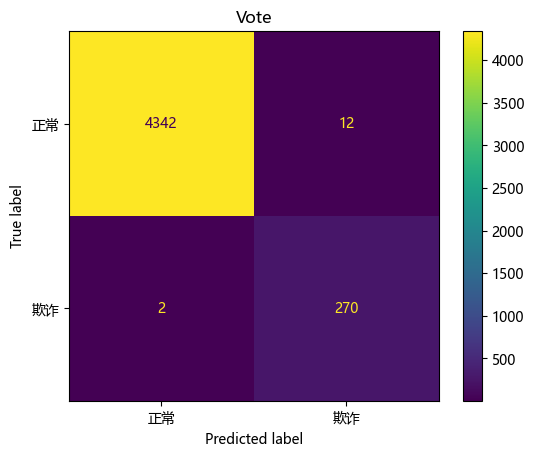

In [243]:
a = train_data_from_frame_voting(X_train, y_train, X_test, y_test)